# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [1]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf

import Audio_functions as af
import UNet
import Dataset

### Get the variables and data ready

In [2]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 10

checkpoint = '46/46-1501'
model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#  Create the pipeline
tf.reset_default_graph()
data = Dataset.zip_files(directory_a, directory_b)
data = Dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, 1:, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, 1:, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, 1:, 0], 3)

In [3]:
data

<PrefetchDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [4]:
# Build U-Net model
print('Creating model')
model = UNet.UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'unet', is_training, name='U_Net_Model')
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [5]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from /home/enterprise.internal.city.ac.uk/acvn728/checkpoints/46/46-1501


### Run a batch

In [6]:
mixture_mag, mix_phase_mag, voice_mag, voice_est_mag, mask, voice_wave = sess.run([model.mixed_mag, model.mixed_phase, model.voice_mag,
                                                                       model.gen_voice, model.voice_mask, model.voice_audio], 
                                                                      {model.is_training:False})
voice_est_wave = list()
mix_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))
    
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mixture_mag[i, :, :, :]).T, n_fft,
                                              fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))

### Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [16]:
len(voice_est_wave)

5

In [17]:
#  The original mixture
ipd.Audio(mix_wave[0], rate=sample_rate)

In [18]:
#  The original isolated voice
ipd.Audio(voice_wave[0].T, rate=sample_rate)

In [19]:
#  The estimated isolated voice produced by the network
ipd.Audio(voice_est_wave[0], rate=sample_rate)

In [20]:
len(voice_est_wave[0])

65280

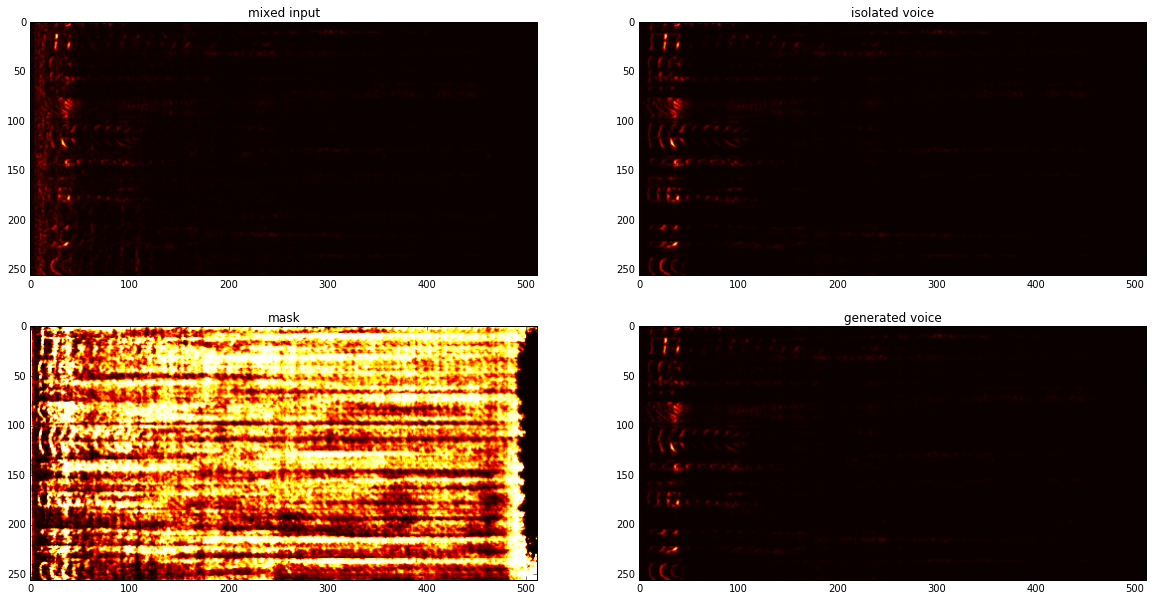

In [21]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mixture_mag[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_mag[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est_mag[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [ ]:
tf.reset_default_graph()

In [9]:
len(voice_est_wave)

5

In [10]:
mixture_mag.shape

(5, 256, 512, 1)

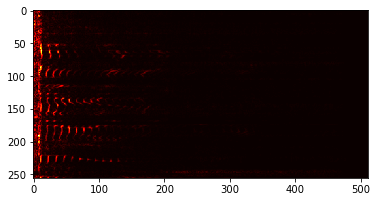

In [11]:
plt.imshow(mixture_mag[0,:,:,0])

In [7]:
audio = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[0, :, :, :]).T, n_fft, 
                                  fft_hop, phaseIterations=5, phase=np.squeeze(mix_phase_mag[0, :, :, :]).T)

ValueError: operands could not be broadcast together with shapes (512,256) (513,256) 

In [42]:
reconstruction = np.exp(np.squeeze(mix_phase_mag[0, :, :, :]).T * 1j)

In [49]:
reconstruction.shape

(512, 256)

In [44]:
spectrum = (np.squeeze(voice_est_mag[0, :, :, :]).T * np.exp(1j * np.angle(reconstruction)))

In [45]:
audio = librosa.istft(spectrum, fft_hop)
type(audio)

numpy.ndarray

In [46]:
audio.shape

(65280,)

In [48]:
reconstruction = librosa.stft(audio, n_fft, fft_hop)[:reconstruction.shape[0],:reconstruction.shape[1]]